# Prétraitement d'une image

Comment converter une image en features ? That is the question.


## scikit-image

La première option est d'utiliser une librairie dédiée aux traitements d'images comme [scikit-image](https://scikit-image.org/). Ce sont des traitements rapides mais simples.

In [5]:
from skimage.io import imread
from skimage.transform import resize

filename = "images/Northern_Pintail_(Male)-_Preening_I_IMG_1119.jpg"
img = imread(filename)
img.dtype, img.shape

(dtype('uint8'), (583, 800, 3))

C'est une image réelle codé sur 3 couleurs. On peut utiliser le package [Pillow](https://pillow.readthedocs.io/en/stable/) également.

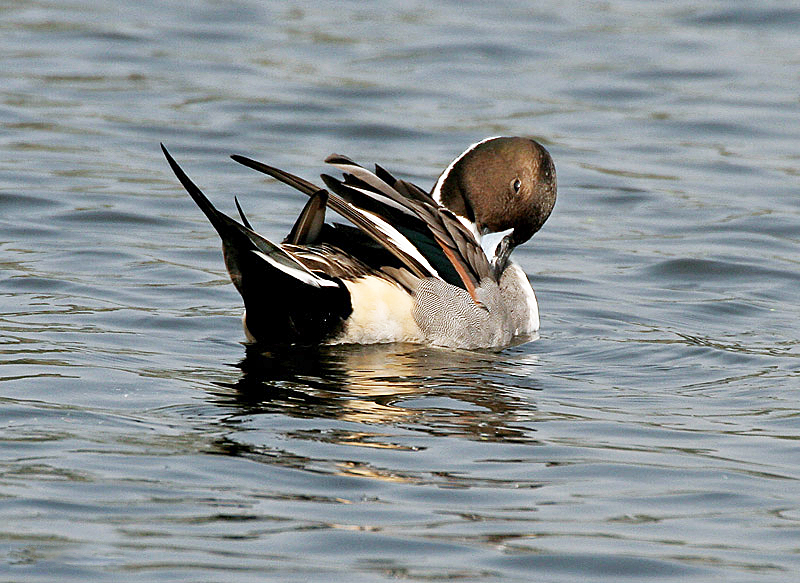

In [6]:
from PIL import Image

imgpil = Image.open(filename)
imgpil

On appliquer des traitements telles que [HOG](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html).

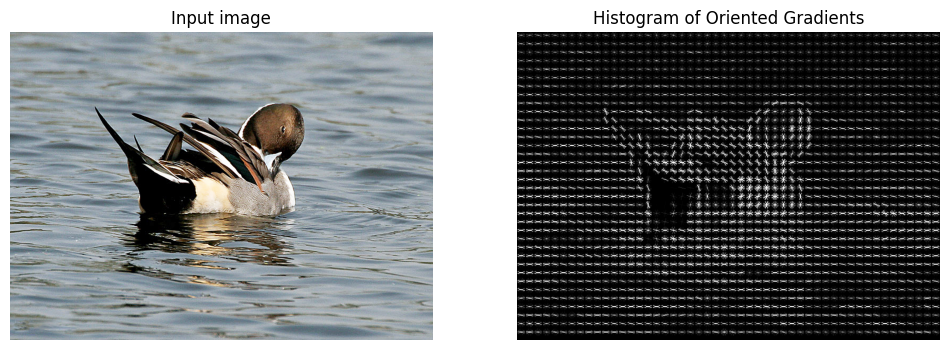

In [13]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.exposure import rescale_intensity

fd, hog_image = hog(
    img,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title("Input image")

# Rescale histogram for better display
hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis("off")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients")
plt.show()

## Prétraitement avancé ou transfer learning

L'idée est d'utiliser un modèle appris sur beaucoup de données, des données dont on ne dispose pas souvent. Il faut utiliser le ou les modèles qui extraient l'information dont les modèles ont besoin, cela peut être de la reconnaissance objets (voir par exemple [YOLO](https://www.youtube.com/watch?v=fRH3YGIASYM)), de la reconnaissance de texte... L'exemple suivant utilise le modèle [MobileNetV2](https://paperswithcode.com/method/mobilenetv2).

In [17]:
from PIL import Image
import numpy as np
from transformers import AutoImageProcessor, MobileNetV2Model

# Charger un modèle léger (ResNet)
MODEL_NAME = "google/mobilenet_v2_1.0_224"
extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

/home/xadupre/vv/this312/lib/python3.12/site-packages/transformers/models/mobilenet_v2/feature_extraction_mobilenet_v2.py:28: FutureWarning: The class MobileNetV2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileNetV2ImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [20]:
import torch


def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.pooler_output.numpy()  # Extraire les features


# Exemple avec une image
embedding = get_image_embedding(filename)
print("Shape embedding image :", embedding.shape, embedding.dtype)  # (1, 2048)

Shape embedding image : (1, 1280) float32


Ces modèles sont constitués de plusieurs couches. Il est possible d'utiliser n'importe laquelle de ces couches pour features. Plus la couche est proche du résultat, plus les features sont loin de l'image et spécialisées pour la tâche pour laquelle ce modèle a été appris.